In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sbn
import os
from functools import cmp_to_key
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from deepctr.inputs import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM
import pickle
from tensorflow.keras import layers
import time
from tensorflow import feature_column
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
def load_dict_from_file(file, type='default', skiprow = 0):
    data = list()
    size = 0
    with open(file, encoding='utf-8') as f:
        for line in f:
            size += 1
            try:
                if size <= skiprow:
                    continue
                line = line.replace('"', '').strip()
                if len(line) <= 0:
                    continue
                if type == 'interet':
                    parts = line.split(",")
                    name = parts[0]
                    size = int(parts[1])
                    if size > 10 and len(name) > 0:
                        data.append(name)
                elif type == 'loc':
                    parts = line.split(",")
                    province = parts[0]
                    city = parts[1]
                    area = parts[2]
                    data.append(province)
                    data.append(province + "_" + city)
                    data.append(province + "_" + city + "_" + area)
                elif type == 'publisher':
                    parts = line.split(",")
                    name = parts[0]
                    size = int(parts[1])
                    if size > 10:
                        data.append(name)
                else:
                    data.append(line)
            except:
                print(line)
    return data

In [4]:
def load_dict(dir, type='default', skiprow = 0):
    data = list()
    size = 0
    files = os.listdir(dir)
    for file in files:
        if not file.endswith(".csv"):
            continue
        data+=load_dict_from_file(dir + "/" + file, type, skiprow)
    return list(set(data))

In [5]:
lbe_file = 'lbe.pickle'
data_map_file = 'data_map.pickle'

In [6]:
def save_pickle_data(file, data):
    f = open(file, 'wb')
    pickle.dump(data, f)
    f.close()


def load_pickle_data(file):
    try:
        f1 = open(file, 'rb')
        return pickle.load(f1)
    except:
        pass
    return None

In [7]:
its = load_dict('/home/recsys/dataset/dict/interets', 'interet')
locs = load_dict('/home/recsys/dataset/dict/loc', 'loc')
publishers = load_dict('/home/recsys/dataset/dict/publisher', 'publisher', 1)
cates = load_dict_from_file('/home/recsys/dataset/dict/cate.csv', 'cate', 1)
channels = load_dict_from_file('/home/recsys/dataset/dict/channel.csv', 'channel', 1)
publishers.append('other')
channels.append('')

u_levels = [str(i) for i in range(0, 10)]
media_levels = [str(i) for i in range(0, 10)]
rschannles = [str(i) for i in range(1, 33)]
vocabs = dict()
vocabs['u_level'] = u_levels
vocabs['t_channel'] = channels
vocabs['cp_l1_category'] = cates
vocabs['cp_publisher'] = publishers
vocabs['cp_media_level'] = media_levels
vocabs['rschannles'] = rschannles

Sky game
中国新闻网,绥芬河政府网站,1
Ansun Biopharma, Inc.,1


In [8]:
len(vocabs)

6

In [9]:
def load_dataset(dir_path):
    files = os.listdir(dir_path)
    print(dir_path)
    dataset = tf.data.TFRecordDataset(filenames = [dir_path + '/' + file for file in files], num_parallel_reads= tf.data.experimental.AUTOTUNE )
    return dataset

In [10]:
# print data set
def print_dataset(data_set):
        iterator = data_set.make_one_shot_iterator()
        next_element = iterator.get_next()
        num_batch = 0
        with tf.train.MonitoredTrainingSession() as sess:
            while not sess.should_stop():
                value = sess.run(next_element)
                num_batch += 1
                print("Num Batch: ", num_batch)
                print("Batch value: ", value)
                
def print_dataset2(data_set):
        iterator = data_set.make_initializable_iterator()
        next_element = iterator.get_next()
        num_batch = 0
        with tf.train.MonitoredTrainingSession() as sess:
            sess.run(iterator.initializer)
            while True:
                try:
                    value = sess.run(next_element)
                    print("Num Batch: ", num_batch)
                    print("Batch value: ", value)
                    #assert j == value
                    #j += 1
                    num_batch += 1
                except tf.errors.OutOfRangeError:
                    break

In [11]:
path = "/home/recsys/dataset/train/2020-05-08-00"

In [12]:
train = load_dataset(path+"/train")
test = load_dataset(path+"/test")

/home/recsys/dataset/train/2020-05-08-00/train
/home/recsys/dataset/train/2020-05-08-00/test


In [13]:
for raw_record in train.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
#     print(example)

In [14]:
import numpy as np

###### 选择特征列 
uid, u_umi, u_umi_weight, u_uli, u_uli_weight, u_usi, u_usi_weight, u_level

t_channel, t_location

item_id, cp_l1_category, cp_interests, cp_location, cp_publisher, cp_media_level, cp_life_hour

rs_channel, rs_gactr, rs_taginfo, rs_taginfo_weight, rs_dactr

In [15]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

class NumpyFunctionHelper:
    def __init__(self, maxlen=None, dtype='int32', padding='post', truncating='post', value=0.0):
        self.maxlen = maxlen
        self.dtype = dtype
        self.padding = padding
        self.truncating = truncating
        self.value = value
        self.out_dtype = tf.int32
        if self.dtype == 'int64':
            self.out_dtype = tf.int64
        elif self.dtype == 'float32':
            self.out_dtype = tf.float32
        return

    def pad_sequences(self, x):
        # x will be a numpy array with the contents of the input to the
        # tf.function
        # note: x will be processed as a list of sequences
        return sequence.pad_sequences(x,
                                      maxlen = self.maxlen,
                                      dtype = self.dtype,
                                      padding = self.padding,
                                      truncating = self.truncating,
                                      value = self.value)

    # tf.numpy_function用于将一个numpy函数转换为一个tensor的operator，以便嵌入到计算图中处理Tensor
    # 构造一个能支持Tensor的填充截断函数
    # 调用方法NumpyFunctionHelper.tf_pad_sequences(helper, in_tensor)
    @tf.function
    def tf_pad_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_sequences, [in_tensor], self.out_dtype)
        return y

    # 毫秒时间戳转换为local的struct_time
    def timestamp_to_time(self, ts):
        st = time.localtime(ts/1000)
        return tf.constant([st.tm_mon, st.tm_mday, st.tm_hour, st.tm_min, st.tm_wday])

    @tf.function
    def tf_timestamp_to_time(self, ts):
        y = tf.py_function(self.timestamp_to_time, ts, self.out_dtype)
        return y
    
    def pad_str_sequences(self, x):
        lst = x.tolist()
        res = []
        if len(x) < self.maxlen:
            for i in range(self.maxlen - len(x)):
                res.append(b'<PAD>')

        return np.asarray(lst + res)[:self.maxlen]
    
    @tf.function
    def tf_pad_str_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_str_sequences, [in_tensor], tf.string)
        return y

In [16]:
max_len = 300
from tensorflow.keras.preprocessing import sequence
def pad_sequences(x):
    # x will be a numpy array with the contents of the input to the
    # tf.function
    # note: x will be processed as a list of sequences
    lst = x.tolist()
    res = []
    if len(x) < max_len:
        for i in range(max_len - len(x)):
            res.append(b'<PAD>')
            
    return np.asarray(lst + res)[:max_len]

In [17]:
def tf_pad_sequences(in_tensor):
    y = tf.numpy_function(pad_sequences, [in_tensor], tf.string)
    return y

In [27]:
def parse_function(example_proto):
    dics = {'action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'uid': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'u_uli': tf.io.VarLenFeature(dtype=tf.string),
#             'u_uli_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_umi': tf.io.VarLenFeature(dtype=tf.string),
#             'u_umi_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_usi': tf.io.VarLenFeature(dtype=tf.string),
#             'u_usi_weight': tf.io.VarLenFeature( dtype=tf.float32),
#             'u_level': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=b'0'),
#             't_channel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
#             't_location': tf.io.VarLenFeature(dtype=tf.string),
            'item_id': tf.io.FixedLenFeature(shape=(1,), dtype=tf.string, default_value=''),
#             't_action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=1),
#             't_scene': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
#             'cp_word_count': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_media_level': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
#             'cp_is_local_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_location': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_is_local': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_l1_category': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_life_hour': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=72),
            'cp_interests': tf.io.VarLenFeature(dtype=tf.string),
            'rs_gactr': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0),
#             'rs_channel': tf.io.VarLenFeature(dtype=tf.string),
            'rs_taginfo': tf.io.VarLenFeature(dtype=tf.string),
#             'rs_dactr': tf.io.VarLenFeature(dtype=tf.float32),
           }
    # parse all features in a single example according to the dics
    parsed_example = tf.io.parse_single_example(example_proto, dics)
    
    max_len = 300
    h = NumpyFunctionHelper(maxlen=max_len, dtype=tf.string, value=b'<PAD>')
    parsed_example['u_uli'] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example['u_uli']))
    parsed_example['u_uli'].set_shape([max_len])
    
    max_len = 10
    h = NumpyFunctionHelper(maxlen=max_len, dtype=tf.string, value=b'<PAD>')
    parsed_example['rs_taginfo'] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example['rs_taginfo']))
    parsed_example['rs_taginfo'].set_shape([max_len])
    
    max_len = 8
    h = NumpyFunctionHelper(maxlen=max_len, dtype=tf.string, value=b'<PAD>')
    parsed_example['cp_interests'] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example['cp_interests']))
    parsed_example['cp_interests'].set_shape([max_len])
#     parsed_example['cp_media_level'] = tf.strings.as_string(parsed_example['cp_media_level'])
    target = parsed_example['action']
    del parsed_example['action']
    return parsed_example, target
train_dataset = train.map(parse_function)
test_dataset = test.map(parse_function)

new_dataset = train_dataset
new_dataset = new_dataset.batch(64)
example_batch = next(iter(new_dataset))[0]

# # feature_column.categorical_column_with_vocabulary_list(key='u_level', vocabulary_list=u_levels, num_oov_buckets=1)
for feature_batch, label_batch in new_dataset.take(1):
    print('Every feature:', list(feature_batch.keys()))
#     print('A batch of u_uli:', feature_batch['u_uli'])
    print('A batch of u_uli:', type(feature_batch['u_uli']))
#     print('A batch of item_id:', feature_batch['u_uli'])
    print('A batch of rs_taginfo:', type(feature_batch['rs_taginfo']))
    print('A batch of targets:', label_batch )

Every feature: ['cp_interests', 'rs_taginfo', 'u_uli', 'item_id', 'rs_gactr']
A batch of u_uli: <class 'tensorflow.python.framework.ops.EagerTensor'>
A batch of rs_taginfo: <class 'tensorflow.python.framework.ops.EagerTensor'>
A batch of targets: tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0], shape=(64,), dtype=int64)


In [25]:
def parse_function(example_proto):
    dics = {'action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'uid': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'u_uli': tf.io.VarLenFeature(dtype=tf.string),
#             'u_uli_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_umi': tf.io.VarLenFeature(dtype=tf.string),
#             'u_umi_weight': tf.io.VarLenFeature(dtype=tf.float32),
#             'u_usi': tf.io.VarLenFeature(dtype=tf.string),
#             'u_usi_weight': tf.io.VarLenFeature( dtype=tf.float32),
#             'u_level': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=b'0'),
#             't_channel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
#             't_location': tf.io.VarLenFeature(dtype=tf.string),
            'item_id': tf.io.FixedLenFeature(shape=(1,), dtype=tf.string, default_value=''),
#             't_action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=1),
#             't_scene': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
#             'cp_word_count': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_media_level': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
#             'cp_is_local_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_location': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_is_local': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
#             'cp_l1_category': tf.io.VarLenFeature(dtype=tf.string),
#             'cp_life_hour': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=72),
            'cp_interests': tf.io.VarLenFeature(dtype=tf.string),
            'rs_gactr': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0),
#             'rs_channel': tf.io.VarLenFeature(dtype=tf.string),
            'rs_taginfo': tf.io.VarLenFeature(dtype=tf.string),
#             'rs_dactr': tf.io.VarLenFeature(dtype=tf.float32),
           }
    # parse all features in a single example according to the dics
    parsed_example = tf.io.parse_single_example(example_proto, dics)
    
    max_len = 300
    h = NumpyFunctionHelper(maxlen=max_len, dtype=tf.string, value=b'<PAD>')
    parsed_example['u_uli'] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example['u_uli']))
    parsed_example['u_uli'].set_shape([max_len])
    
    max_len = 10
    h = NumpyFunctionHelper(maxlen=max_len, dtype=tf.string, value=b'<PAD>')
    parsed_example['rs_taginfo'] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example['rs_taginfo']))
    parsed_example['rs_taginfo'].set_shape([max_len])
    
    max_len = 8
    h = NumpyFunctionHelper(maxlen=max_len, dtype=tf.string, value=b'<PAD>')
    parsed_example['cp_interests'] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example['cp_interests']))
    parsed_example['cp_interests'].set_shape([max_len])
#     parsed_example['cp_media_level'] = tf.strings.as_string(parsed_example['cp_media_level'])
    target = parsed_example['action']
    del parsed_example['action']
    return parsed_example, target
train_dataset = train.map(parse_function)
test_dataset = test.map(parse_function)

new_dataset = train_dataset
new_dataset = new_dataset.batch(64)
example_batch = next(iter(new_dataset))[0]

# # feature_column.categorical_column_with_vocabulary_list(key='u_level', vocabulary_list=u_levels, num_oov_buckets=1)
for feature_batch, label_batch in new_dataset.take(1):
    print('Every feature:', list(feature_batch.keys()))
#     print('A batch of u_uli:', feature_batch['u_uli'])
    print('A batch of u_uli:', type(feature_batch['u_uli']))
#     print('A batch of item_id:', feature_batch['u_uli'])
#     print('A batch of rs_taginfo:', feature_batch['rs_taginfo'])
#     print('A batch of targets:', label_batch )
    
# 用于创建一个特征列
# 并转换一批次数据的一个实用程序方法
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    return feature_layer(example_batch).numpy()

#选择特征列
feature_columns = []
feature_layer_inputs = {}

feature_columns.append(feature_column.numeric_column("rs_gactr"))
feature_layer_inputs["rs_gactr"] = tf.keras.Input(shape=(1,), name="rs_gactr", dtype='float32')

item_id_hash = feature_column.categorical_column_with_hash_bucket('item_id', hash_bucket_size=500000)
item_id_one_hot = feature_column.indicator_column(item_id_hash)
feature_columns.append(item_id_one_hot)
feature_layer_inputs['item_id'] = tf.keras.Input(shape=(1,), name='item_id', dtype=tf.string)
item_id_embedding = feature_column.embedding_column(item_id_hash, dimension=64)
feature_columns.append(item_id_embedding)

# uid_hash = feature_column.categorical_column_with_hash_bucket('uid', hash_bucket_size=500000)
# uid_embedding = feature_column.embedding_column(uid_hash, dimension=64)
# feature_columns.append(uid_embedding)
# feature_layer_inputs["uid"] = tf.keras.Input(shape=(), name="uid", dtype='string')


u_uli = feature_column.categorical_column_with_hash_bucket('u_uli', hash_bucket_size=30000, dtype=tf.string)
u_uli_one_hot = feature_column.indicator_column(u_uli)
feature_columns.append(u_uli_one_hot)
feature_layer_inputs["u_uli"] = tf.keras.Input(shape=(300,), name="u_uli", dtype=tf.string)
u_uli_embedding = feature_column.embedding_column(u_uli, dimension=64)
feature_columns.append(u_uli_embedding)

# feature_layer_inputs["u_uli"] = tf.keras.Input(shape=(1,), sparse=True, dtype=tf.string, name="u_uli")

# u_umi = feature_column.categorical_column_with_vocabulary_list('u_umi', vocabulary_list=its, num_oov_buckets=1)
# u_umi_embedding = feature_column.embedding_column(u_umi, dimension=64)
# feature_columns.append(u_umi_embedding)

# u_usi = feature_column.categorical_column_with_vocabulary_list('u_usi', vocabulary_list=its, num_oov_buckets=1)
# u_usi_embedding = feature_column.embedding_column(u_usi, dimension=64)
# feature_columns.append(u_usi_embedding)

# u_level = feature_column.categorical_column_with_vocabulary_list('u_level', vocabulary_list=u_levels, num_oov_buckets=1)
# u_level_one_hot = feature_column.indicator_column(u_level)
# feature_columns.append(u_level_one_hot)

# t_channel = feature_column.categorical_column_with_vocabulary_list('t_channel', vocabulary_list=channels, num_oov_buckets=1)
# t_channel_one_hot = feature_column.indicator_column(t_channel)
# feature_columns.append(t_channel_one_hot)

# t_location = feature_column.categorical_column_with_vocabulary_list('t_location', vocabulary_list=locs, num_oov_buckets=1)
# t_location_one_hot = feature_column.indicator_column(t_location)
# feature_columns.append(t_location_one_hot)

# cp_media_level = feature_column.categorical_column_with_vocabulary_list('cp_media_level', vocabulary_list=media_levels, num_oov_buckets=1)
# cp_media_level_one_hot = feature_column.indicator_column(cp_media_level)
# feature_columns.append(cp_media_level_one_hot)

# cp_publisher = feature_column.categorical_column_with_vocabulary_list('cp_publisher', vocabulary_list=publishers, num_oov_buckets=1)
# cp_publisher_one_hot = feature_column.indicator_column(cp_publisher)
# feature_columns.append(cp_publisher_one_hot)

# cp_location = feature_column.categorical_column_with_vocabulary_list('cp_location', vocabulary_list=locs, num_oov_buckets=1)
# cp_location_embedding = feature_column.embedding_column(cp_location, dimension=8)
# feature_columns.append(cp_location_embedding)

# cp_life_hour = feature_column.numeric_column("cp_life_hour")
# cp_life_hour = feature_column.bucketized_column(cp_life_hour, boundaries=[72, 24 * 7, 24 * 14, 24 * 30])
# feature_columns.append(cp_life_hour)

# rs_channel = feature_column.categorical_column_with_vocabulary_list('rs_channel', vocabulary_list=rschannles, num_oov_buckets=1)
# rs_channel_embedding = feature_column.embedding_column(rs_channel, dimension=6)
# feature_columns.append(rs_channel_embedding)

# rs_taginfo = feature_column.categorical_column_with_vocabulary_list('rs_taginfo', vocabulary_list=its, num_oov_buckets=1)
# rs_taginfo_embedding = feature_column.embedding_column(rs_taginfo, dimension=8)
# feature_columns.append(rs_taginfo_embedding)

rs_taginfo = feature_column.categorical_column_with_hash_bucket('rs_taginfo', hash_bucket_size=30000, dtype=tf.string)
rs_taginfo_one_hot = feature_column.indicator_column(rs_taginfo)
feature_columns.append(rs_taginfo_one_hot)
feature_layer_inputs["rs_taginfo"] = tf.keras.Input(shape=(10,), name="rs_taginfo", dtype=tf.string)
rs_taginfo_embedding = feature_column.embedding_column(rs_taginfo, dimension=8)
feature_columns.append(rs_taginfo_embedding)

#构造输入特征
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
feature_layer_outputs = feature_layer(feature_layer_inputs)
batch_size = 128
buffer_size = 5000
train_dataset = train_dataset.repeat(10).shuffle(buffer_size).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size).batch(batch_size)


#定义模型
dense1 = tf.keras.layers.Dense(128, activation='relu')(feature_layer_outputs)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
model = tf.keras.Model(inputs=feature_layer_inputs, outputs=dense3)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_crossentropy', 'accuracy', tf.keras.metrics.AUC()],
              run_eagerly=True)

# 模型训练
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=10)

Every feature: ['cp_interests', 'rs_taginfo', 'u_uli', 'item_id', 'rs_gactr']
A batch of u_uli: <class 'tensorflow.python.framework.ops.EagerTensor'>
1142/1142 [==============================] - 352s 308ms/step - loss: 0.2749 - binary_crossentropy: 0.2749 - accuracy: 0.8991 - auc_1: 0.7887 - val_loss: 0.3597 - val_binary_crossentropy: 0.3653 - val_accuracy: 0.8980 - val_auc_1: 0.6681


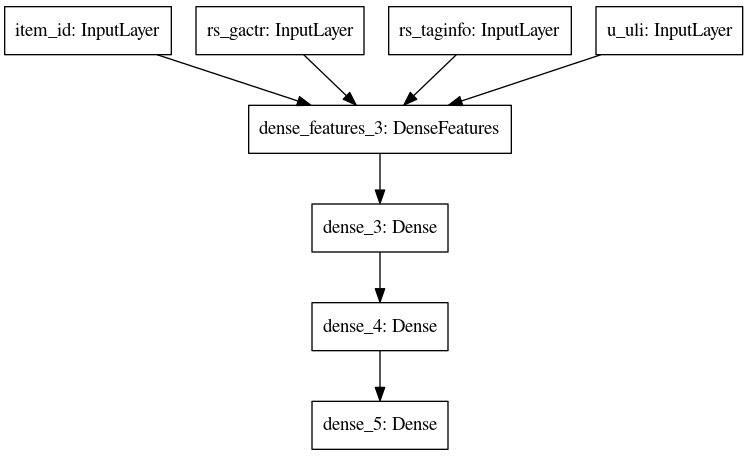

In [26]:
plot_model(model, "deepfm.png")

In [153]:
demo(item_id_embedding).shape

[[ 0.18971294  0.04961373 -0.19117878 ...  0.04181842  0.0559338
  -0.0354376 ]
 [-0.12126184 -0.01599275 -0.01602121 ...  0.24969533 -0.00577582
   0.01080038]
 [-0.12126184 -0.01599275 -0.01602121 ...  0.24969533 -0.00577582
   0.01080038]
 ...
 [ 0.23176633 -0.0812902  -0.00957167 ...  0.19255221  0.19825476
   0.08748969]
 [-0.12886588  0.01968288 -0.01812283 ... -0.22047816  0.2085035
  -0.09212628]
 [-0.06101322  0.00323148  0.07808689 ...  0.15657379  0.02938868
  -0.02438149]]


(64, 64)

In [155]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [156]:
type(feature_layer_outputs)

tensorflow.python.framework.ops.Tensor

In [157]:
# for feature_batch, label_batch in train_dataset.take(1):
#     print('Every feature:', list(feature_batch.keys()))
#     print(type(feature_batch['item_id']))
#     print(type(feature_batch['uid']))

In [158]:
dense1 = tf.keras.layers.Dense(128, activation='relu')(feature_layer_outputs)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
dense3 = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
model = tf.keras.Model(inputs=feature_layer_inputs, outputs=dense3)

In [159]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_crossentropy', 'accuracy', tf.keras.metrics.AUC()],
              run_eagerly=True)

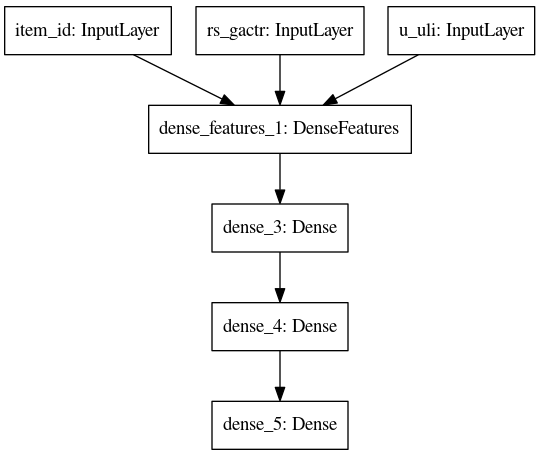

In [74]:
plot_model(model, "deepfm.png")

In [93]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=1)

ValueError: in converted code:

    /home/recsys/.pyenv/versions/3.6.10/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/recsys/.pyenv/versions/3.6.10/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py:2410 _standardize_tensors
        exception_prefix='input')
    /home/recsys/.pyenv/versions/3.6.10/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected item_id to have 2 dimensions, but got array with shape (None, None, None)


In [52]:
def MyExampleModel(feature_columns, field_metas, learning_rate=0.01):
    feature_layer_inputs = dict()
    for fm in field_metas:
        feature_layer_inputs[fm.name] = tf.keras.Input(shape=(fm.shape), name=fm.name, dtype=fm.dtype)
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    feature_layer_outputs = feature_layer(feature_layer_inputs)

    x = layers.Dense(128, activation='relu')(feature_layer_outputs)
    x = layers.Dense(64, activation='relu')(x)
    pred = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=[v for v in feature_layer_inputs.values()], outputs=pred)

def loss(output, labels):
    labels = tf.reshape(labels, [-1])
    return tf.reduce_mean(
        input_tensor=tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=output, labels=labels
        )
    )

def optimizer(lr=0.1):
    return tf.optimizers.SGD(lr)

def prepare_prediction_column(self, prediction):
    """Return the class label of highest probability."""
    return prediction.argmax(axis=-1)